In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils import data

## F-MNIST dataset

In [2]:
import datasets
from classes import *

In [3]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [4]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [5]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

In [6]:
network_seeds = [147, 258, 369]
# network_seeds = [369]
network_seed = 369

EPOCHS = 20

actf = nn.LeakyReLU
# actf = nn.ELU

learning_rate = 0.005
lambda_ = 2
criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()

use_mixup = True

In [7]:
class MNIST_OneClass_Balanced(data.Dataset):
    
    def __init__(self, data, label, class_index):
        self.data = data
        self.label = label
        self.class_index = class_index
        
        mask = (label==class_index)
        self.label = mask.type(torch.float32).reshape(-1,1)
        self.class_data = torch.nonzero(mask).reshape(-1)
        self.other_data = torch.nonzero(~mask).reshape(-1)
        
        random.seed(network_seed)
        self._shuffle_data_()
        self.count = 0
        
    def __len__(self):
        return 2*len(self.class_data)
    
    def _shuffle_data_(self):
#         randidx = np.random.permutation(len(self.other_data))
        randidx = random.sample(range(len(self.other_data)), k=len(self.other_data))
        self.other_data = self.other_data[randidx]
    
    def __getitem__(self, idx):
        if idx < len(self.class_data):
            idx = self.class_data[idx]
            img, lbl = self.data[idx], self.label[idx]
        else:
            idx = self.other_data[idx-len(self.class_data)]
            img, lbl = self.data[idx], self.label[idx]
            self.count += 1
            if self.count >= len(self.class_data): 
                self._shuffle_data_()
                self.count = 0
        return img, lbl

In [8]:
# class_idx = 0
# train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
# test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

In [9]:
# len(train_dataset), len(test_dataset)

In [10]:
# train_loader_all = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
# test_loader_all = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [11]:
# %matplotlib inline
# # img, lbl = train_dataset[11010]
# img, lbl = test_dataset[10]
# print(lbl)
# plt.imshow(img.reshape(28,28))

## Convex

In [12]:
class UnivariateCNN(nn.Module):
    
    def __init__(self, channels:list, actf=nn.LeakyReLU):
        super().__init__()
        assert len(channels)>1

        layers = []
        for i in range(len(channels)-1):
            la = nn.Conv2d(channels[i], channels[i+1], kernel_size=(5,5), stride=2, padding=1)
            layers.append(la)
            layers.append(actf())
        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(channels[-1], 1))
        
    def forward(self, x):
        x = x.reshape(-1,1, 28, 28)
        x = self.features(x)
        s = x.shape
        return self.fc(x.reshape(s[0], s[1]))    
    

class ConvexCNN(nn.Module):
    
    def __init__(self, channels:list, actf=nn.LeakyReLU):
        super().__init__()
        assert len(channels)>1

        layers = []
        for i in range(len(channels)-1):
            la = nn.Conv2d(channels[i], channels[i+1], kernel_size=(5,5), stride=2, padding=1)
            layers.append(la)
            if i>0:
                layers[-1].weight.data *= 0.1
            layers.append(actf())
        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(channels[-1], 1))
        
    def forward(self, x):
        x = x.reshape(-1,1,28, 28)
        for i in range(2, len(self.features)-1, 2):
            self.features[i].weight.data.abs_()
        for i in range(0, len(self.fc), 2):
            self.fc[i].weight.data.abs_()
            
        x = self.features(x)
        s = x.shape
        return self.fc(x.reshape(s[0], s[1]))    
    


In [13]:
# cnn = UnivariateCNN([1, 16, 32, 64])
# cnn = ConvexCNN([1, 32, 32])
# cnn(torch.randn(2,1,28,28))

In [14]:
# a = nn.Sequential(nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2),
#              nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2))
# # b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=4)
# b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2, dilation=2)
# x = torch.randn(2,1,32,32)

# a(x).shape, b(x).shape

In [15]:
# a = nn.Sequential(nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=2),
#                  nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2),
#                  nn.Conv2d(1,1, kernel_size=5, padding=2, stride=2))
# b = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=4, dilation=4)
# x = torch.randn(2,1,28,28)
# # nn.Conv2d()

# a(x).shape, b(x).shape

In [16]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = ConvexCNN([1, 32, 32], actf)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
#     EPOCHS = 5
    for epoch in range(EPOCHS):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:240,  Loss:0.3916172683238983
Train Acc:71.54%, Test Acc:83.55%

Epoch: 1:480,  Loss:0.45058688521385193
Train Acc:83.94%, Test Acc:84.55%

Epoch: 2:720,  Loss:0.3130709230899811
Train Acc:85.67%, Test Acc:85.65%

Epoch: 3:960,  Loss:0.32854965329170227
Train Acc:86.60%, Test Acc:87.10%

Epoch: 4:1200,  Loss:0.31756097078323364
Train Acc:87.72%, Test Acc:87.70%

Epoch: 5:1440,  Loss:0.3483291268348694
Train Acc:88.07%, Test Acc:88.60%

Epoch: 6:1680,  Loss:0.2884763479232788
Train Acc:88.57%, Test Acc:87.90%

Epoch: 7:1920,  Loss:0.3030163049697876
Train Acc:88.95%, Test Acc:89.00%

Epoch: 8:2160,  Loss:0.34026864171028137
Train Acc:88.83%, Test Acc:88.50%

Epoch: 9:2400,  Loss:0.5047163963317871
Train Acc:89.42%, Test Acc:89.05%

Epoch: 10:2640,  Loss:0.317220002412796
Train Acc:89.66%, Test Acc:90.55%

Epoch: 11:2880,  Loss:0.2780841588973999
Train Acc:89.88%, Test Acc:90.70%

Epoch: 12:3120,  Loss:0.33498460054397583
Train Acc:90.00%, Test Acc:90.85%

Epoch: 13:3360,  Los

Train Acc:94.44%, Test Acc:97.00%

Epoch: 5:1440,  Loss:0.1611485630273819
Train Acc:95.47%, Test Acc:96.85%

Epoch: 6:1680,  Loss:0.17929226160049438
Train Acc:95.33%, Test Acc:97.40%

Epoch: 7:1920,  Loss:0.17010027170181274
Train Acc:95.51%, Test Acc:97.75%

Epoch: 8:2160,  Loss:0.24159477651119232
Train Acc:95.58%, Test Acc:97.85%

Epoch: 9:2400,  Loss:0.19911396503448486
Train Acc:96.02%, Test Acc:97.15%

Epoch: 10:2640,  Loss:0.16116367280483246
Train Acc:95.79%, Test Acc:97.25%

Epoch: 11:2880,  Loss:0.20184607803821564
Train Acc:96.04%, Test Acc:97.95%

Epoch: 12:3120,  Loss:0.25237977504730225
Train Acc:96.16%, Test Acc:97.65%

Epoch: 13:3360,  Loss:0.13917119801044464
Train Acc:96.18%, Test Acc:97.50%

Epoch: 14:3600,  Loss:0.21335984766483307
Train Acc:95.95%, Test Acc:97.30%

Epoch: 15:3840,  Loss:0.17866307497024536
Train Acc:96.37%, Test Acc:97.30%

Epoch: 16:4080,  Loss:0.1501874029636383
Train Acc:96.21%, Test Acc:96.40%

Epoch: 17:4320,  Loss:0.1816568374633789
Train A

In [17]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 90.63333333333333 ; Test Acc 91.45
Class: 1 -> Train Acc 97.975 ; Test Acc 97.8
Class: 2 -> Train Acc 89.46666666666667 ; Test Acc 89.35
Class: 3 -> Train Acc 92.26666666666667 ; Test Acc 92.35
Class: 4 -> Train Acc 88.375 ; Test Acc 88.25
Class: 5 -> Train Acc 96.36666666666667 ; Test Acc 97.95
Class: 6 -> Train Acc 80.15 ; Test Acc 81.3
Class: 7 -> Train Acc 93.475 ; Test Acc 93.35
Class: 8 -> Train Acc 97.2 ; Test Acc 97.2
Class: 9 -> Train Acc 95.72500000000001 ; Test Acc 96.0
Total Accuracy (Argmax) is : 0.8100000023841858


## NN

In [18]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = UnivariateCNN([1, 32, 32], actf)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(EPOCHS):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:240,  Loss:0.216309055685997
Train Acc:82.99%, Test Acc:89.95%

Epoch: 1:480,  Loss:0.3652743995189667
Train Acc:90.76%, Test Acc:92.00%

Epoch: 2:720,  Loss:0.15392237901687622
Train Acc:92.14%, Test Acc:93.30%

Epoch: 3:960,  Loss:0.23149675130844116
Train Acc:93.04%, Test Acc:92.45%

Epoch: 4:1200,  Loss:0.24943964183330536
Train Acc:93.17%, Test Acc:94.15%

Epoch: 5:1440,  Loss:0.26724010705947876
Train Acc:93.47%, Test Acc:94.05%

Epoch: 6:1680,  Loss:0.2598860263824463
Train Acc:93.85%, Test Acc:92.95%

Epoch: 7:1920,  Loss:0.15507887303829193
Train Acc:93.94%, Test Acc:93.60%

Epoch: 8:2160,  Loss:0.2669059634208679
Train Acc:94.16%, Test Acc:94.00%

Epoch: 9:2400,  Loss:0.34511664509773254
Train Acc:94.61%, Test Acc:94.35%

Epoch: 10:2640,  Loss:0.19656597077846527
Train Acc:94.60%, Test Acc:93.95%

Epoch: 11:2880,  Loss:0.15817105770111084
Train Acc:94.77%, Test Acc:94.70%

Epoch: 12:3120,  Loss:0.22251026332378387
Train Acc:95.04%, Test Acc:94.90%

Epoch: 13:3360, 

Epoch: 4:1200,  Loss:0.17750392854213715
Train Acc:96.67%, Test Acc:97.85%

Epoch: 5:1440,  Loss:0.1228071004152298
Train Acc:97.43%, Test Acc:98.05%

Epoch: 6:1680,  Loss:0.1598832756280899
Train Acc:97.67%, Test Acc:98.00%

Epoch: 7:1920,  Loss:0.16555827856063843
Train Acc:97.76%, Test Acc:98.15%

Epoch: 8:2160,  Loss:0.19751867651939392
Train Acc:97.68%, Test Acc:98.45%

Epoch: 9:2400,  Loss:0.2192445695400238
Train Acc:98.07%, Test Acc:97.00%

Epoch: 10:2640,  Loss:0.12669995427131653
Train Acc:98.15%, Test Acc:98.05%

Epoch: 11:2880,  Loss:0.15899983048439026
Train Acc:98.45%, Test Acc:98.85%

Epoch: 12:3120,  Loss:0.12834244966506958
Train Acc:98.58%, Test Acc:98.35%

Epoch: 13:3360,  Loss:0.12457013130187988
Train Acc:98.74%, Test Acc:98.55%

Epoch: 14:3600,  Loss:0.1431899219751358
Train Acc:98.62%, Test Acc:98.20%

Epoch: 15:3840,  Loss:0.13196691870689392
Train Acc:98.83%, Test Acc:99.20%

Epoch: 16:4080,  Loss:0.13940311968326569
Train Acc:98.92%, Test Acc:99.00%

Epoch: 17

In [19]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 95.60833333333333 ; Test Acc 95.25
Class: 1 -> Train Acc 99.39166666666667 ; Test Acc 99.2
Class: 2 -> Train Acc 94.63333333333334 ; Test Acc 93.45
Class: 3 -> Train Acc 97.34166666666667 ; Test Acc 95.55
Class: 4 -> Train Acc 95.05833333333334 ; Test Acc 93.5
Class: 5 -> Train Acc 99.18333333333334 ; Test Acc 99.25
Class: 6 -> Train Acc 91.23333333333333 ; Test Acc 88.05
Class: 7 -> Train Acc 98.97500000000001 ; Test Acc 98.65
Class: 8 -> Train Acc 99.05833333333334 ; Test Acc 98.55000000000001
Class: 9 -> Train Acc 98.625 ; Test Acc 98.6
Total Accuracy (Argmax) is : 0.8781999945640564


# Invex

In [20]:
# use_mixup = False
use_check = False
check_every = 2
check_size = 100

m_,s_ = 1, 0

In [21]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    lips_net = UnivariateCNN([1, 32, 32], actf)
    Net = BasicInvexNet(784, lips_net, lambda_)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
#     for epoch in range(5):
    for epoch in range(EPOCHS):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
            
            optimizer.zero_grad()
            if use_check and epoch%check_every == 0:
                rand_inp = torch.rand(check_size, 784)*m_+s_
                Net(rand_inp)
                Net.compute_penalty_and_clipper()
                Net.gp.backward(retain_graph=True)
            
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))   
            Net.compute_penalty_and_clipper()
            loss = criterion(yout, y_mix) + Net.gp
            losses.append(float(loss))

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            loss.backward()
            optimizer.step()

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        min_val, gp = float(Net.cond.min()) , float(Net.gp)
        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}, MinVal:{min_val}, gp: {gp}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
#                     with torch.no_grad():
            yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:240,  Loss:0.18971188366413116, MinVal:0.1632585972547531, gp: 0.00010650209878804162
Train Acc:76.20%, Test Acc:90.50%

Epoch: 1:480,  Loss:0.35701411962509155, MinVal:0.28042489290237427, gp: 1.3350414747037576e-06
Train Acc:91.28%, Test Acc:93.10%

Epoch: 2:720,  Loss:0.187253937125206, MinVal:0.2852265536785126, gp: 7.473807386304543e-07
Train Acc:92.83%, Test Acc:93.90%

Epoch: 3:960,  Loss:0.24048782885074615, MinVal:0.2755976915359497, gp: 1.867467744887108e-06
Train Acc:93.78%, Test Acc:93.65%

Epoch: 4:1200,  Loss:0.23840582370758057, MinVal:0.26690617203712463, gp: 1.5967449371601106e-06
Train Acc:93.97%, Test Acc:94.45%

Epoch: 5:1440,  Loss:0.24406932294368744, MinVal:0.4653484523296356, gp: 8.621184877100063e-10
Train Acc:94.04%, Test Acc:94.65%

Epoch: 6:1680,  Loss:0.2369231879711151, MinVal:0.38780477643013, gp: 1.2746019351084215e-08
Train Acc:94.53%, Test Acc:93.55%

Epoch: 7:1920,  Loss:0.18504291772842407, MinVal:0.4172033369541168, gp: 4.69127359181698e-

Train Acc:92.64%, Test Acc:92.70%

Epoch: 2:720,  Loss:0.3357734978199005, MinVal:0.16378065943717957, gp: 8.439631346846e-05
Train Acc:93.50%, Test Acc:93.00%

Epoch: 3:960,  Loss:0.14921978116035461, MinVal:0.26051223278045654, gp: 3.55812017005519e-06
Train Acc:94.06%, Test Acc:94.05%

Epoch: 4:1200,  Loss:0.17220914363861084, MinVal:0.3203987777233124, gp: 2.775753387140867e-07
Train Acc:94.93%, Test Acc:94.10%

Epoch: 5:1440,  Loss:0.24314171075820923, MinVal:0.3461531698703766, gp: 1.073437090326479e-07
Train Acc:95.38%, Test Acc:94.45%

Epoch: 6:1680,  Loss:0.2547254264354706, MinVal:0.3956558406352997, gp: 2.6203810676861394e-08
Train Acc:95.55%, Test Acc:95.05%

Epoch: 7:1920,  Loss:0.2214222252368927, MinVal:0.34414950013160706, gp: 7.316733530160491e-08
Train Acc:95.60%, Test Acc:95.10%

Epoch: 8:2160,  Loss:0.1898137778043747, MinVal:0.36315059661865234, gp: 3.4433909945619234e-08
Train Acc:96.06%, Test Acc:95.05%

Epoch: 9:2400,  Loss:0.17345134913921356, MinVal:0.47677710

Train Acc:82.48%, Test Acc:81.80%

Epoch: 4:1200,  Loss:0.3633200526237488, MinVal:0.35089272260665894, gp: 6.876577884895596e-08
Train Acc:84.30%, Test Acc:83.85%

Epoch: 5:1440,  Loss:0.33880382776260376, MinVal:0.27326133847236633, gp: 1.2028791616103263e-06
Train Acc:86.28%, Test Acc:85.80%

Epoch: 6:1680,  Loss:0.30486178398132324, MinVal:0.358905166387558, gp: 5.477998854530597e-08
Train Acc:87.12%, Test Acc:85.45%

Epoch: 7:1920,  Loss:0.3934882879257202, MinVal:0.28173768520355225, gp: 8.543957505935396e-07
Train Acc:87.81%, Test Acc:86.05%

Epoch: 8:2160,  Loss:0.48420682549476624, MinVal:0.34059277176856995, gp: 1.085781207166292e-07
Train Acc:88.51%, Test Acc:86.25%

Epoch: 9:2400,  Loss:0.20441678166389465, MinVal:0.3639484941959381, gp: 3.9923069294900415e-08
Train Acc:89.14%, Test Acc:86.35%

Epoch: 10:2640,  Loss:0.320590615272522, MinVal:0.3412117660045624, gp: 8.205758916801642e-08
Train Acc:89.35%, Test Acc:86.40%

Epoch: 11:2880,  Loss:0.20236873626708984, MinVal:0.4

Train Acc:97.77%, Test Acc:97.80%

Epoch: 6:1680,  Loss:0.21586839854717255, MinVal:0.39354777336120605, gp: 1.2252090897391099e-08
Train Acc:97.92%, Test Acc:97.95%

Epoch: 7:1920,  Loss:0.20365197956562042, MinVal:0.38677746057510376, gp: 1.509873470695311e-08
Train Acc:97.97%, Test Acc:97.85%

Epoch: 8:2160,  Loss:0.13109473884105682, MinVal:0.7897365689277649, gp: 1.44541344361147e-15
Train Acc:98.07%, Test Acc:97.95%

Epoch: 9:2400,  Loss:0.1484050303697586, MinVal:0.24871042370796204, gp: 3.1730719456390943e-06
Train Acc:98.15%, Test Acc:97.40%

Epoch: 10:2640,  Loss:0.15138190984725952, MinVal:0.6926272511482239, gp: 7.158003031450255e-14
Train Acc:98.18%, Test Acc:98.35%

Epoch: 11:2880,  Loss:0.13007353246212006, MinVal:0.3812703490257263, gp: 1.6694190918542517e-08
Train Acc:98.27%, Test Acc:98.40%

Epoch: 12:3120,  Loss:0.13380101323127747, MinVal:0.7960437536239624, gp: 2.0742396922247483e-15
Train Acc:98.23%, Test Acc:98.30%

Epoch: 13:3360,  Loss:0.1418057680130005, MinVa

In [22]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 95.96666666666667 ; Test Acc 94.89999999999999
Class: 1 -> Train Acc 99.41666666666666 ; Test Acc 99.05000000000001
Class: 2 -> Train Acc 94.96666666666667 ; Test Acc 93.5
Class: 3 -> Train Acc 97.41666666666666 ; Test Acc 96.15
Class: 4 -> Train Acc 95.25 ; Test Acc 93.35
Class: 5 -> Train Acc 99.29166666666667 ; Test Acc 99.0
Class: 6 -> Train Acc 92.15 ; Test Acc 88.4
Class: 7 -> Train Acc 98.94166666666668 ; Test Acc 98.65
Class: 8 -> Train Acc 99.30833333333334 ; Test Acc 98.7
Class: 9 -> Train Acc 98.775 ; Test Acc 98.4
Total Accuracy (Argmax) is : 0.8799999952316284


In [23]:
## Check the constraint on large number of points, including training and test data.

for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    for i in tqdm(range(20000)):
        xx = torch.rand(batch_size, 784)
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

100%|██████████████████████████████████████████████| 20000/20000 [00:34<00:00, 579.88it/s]


Class: 0 -> Correct 99.9695% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:34<00:00, 587.92it/s]


Class: 1 -> Correct 100.0000% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:34<00:00, 582.94it/s]


Class: 2 -> Correct 99.3549% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:33<00:00, 588.57it/s]


Class: 3 -> Correct 99.9803% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:34<00:00, 587.15it/s]


Class: 4 -> Correct 98.3036% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:33<00:00, 588.39it/s]


Class: 5 -> Correct 88.3637% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:33<00:00, 588.26it/s]


Class: 6 -> Correct 99.9966% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:34<00:00, 587.86it/s]


Class: 7 -> Correct 99.9786% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:33<00:00, 588.90it/s]


Class: 8 -> Correct 99.9997% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:33<00:00, 592.40it/s]

Class: 9 -> Correct 100.0000% on 1070000 input points


In [25]:
## only on training and testing data
for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

Class: 0 -> Correct 99.9986% on 70000 input points
Class: 1 -> Correct 100.0000% on 70000 input points
Class: 2 -> Correct 100.0000% on 70000 input points
Class: 3 -> Correct 100.0000% on 70000 input points
Class: 4 -> Correct 100.0000% on 70000 input points
Class: 5 -> Correct 100.0000% on 70000 input points
Class: 6 -> Correct 100.0000% on 70000 input points
Class: 7 -> Correct 100.0000% on 70000 input points
Class: 8 -> Correct 100.0000% on 70000 input points
Class: 9 -> Correct 100.0000% on 70000 input points


In [ ]:
# net(xx)

In [26]:
sum([torch.numel(p) for p in Net.parameters()])

27281

In [27]:
# net.compute_penalty_and_clipper()

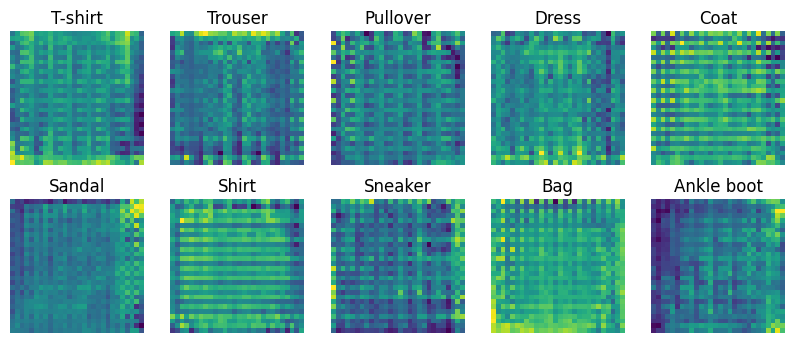

In [28]:
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    icenter = invNet.center.data
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{classes[i]}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/FashionMNIST_BasicInvex_cnn_centroids.pdf")
plt.show()

## Invertible+Cone = Invex

In [29]:
from nflib.flows import SequentialFlow, ActNorm, ActNorm2D
from nflib import res_flow as irf

In [30]:
from classes import DistanceRegressor

In [44]:
class InvCNN_MNIST(nn.Module):
    
    def __init__(self):
        super().__init__()
        actf = irf.LeakyReLU

        flows = [
            ActNorm2D(1),
            irf.ConvResidualFlow([1, 28, 28], [16], kernels=5, activation=actf),
            irf.InvertiblePooling(2),
            ActNorm2D(4),
            irf.ConvResidualFlow([4, 14, 14], [16], kernels=5, activation=actf),
            irf.InvertiblePooling(2),
            ActNorm2D(16),
            irf.ConvResidualFlow([16, 7, 7], [16], kernels=5, activation=actf),
            irf.Flatten(img_size=(16, 7, 7)),
            ActNorm(16*7*7),
            DistanceRegressor(16*7*7, inv_temp=0.25)
                ]
        self.model = nn.Sequential(*flows)
    
    def forward(self, x):
        x = x.reshape(-1,1, 28, 28)
        return self.model(x)

In [45]:
sum([torch.numel(p) for p in InvCNN_MNIST().parameters()])

19265

In [46]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = InvCNN_MNIST()
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
            with torch.no_grad():
                yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:240,  Loss:0.4238908290863037
Train Acc:70.42%, Test Acc:86.05%

Epoch: 1:480,  Loss:0.30768662691116333
Train Acc:90.57%, Test Acc:93.05%

Epoch: 2:720,  Loss:0.23937709629535675
Train Acc:92.93%, Test Acc:93.45%

Epoch: 3:960,  Loss:0.32441815733909607
Train Acc:93.82%, Test Acc:93.85%

Epoch: 4:1200,  Loss:0.286790132522583
Train Acc:93.85%, Test Acc:94.40%

Epoch: 5:1440,  Loss:0.24869169294834137
Train Acc:94.18%, Test Acc:93.75%

Epoch: 6:1680,  Loss:0.21432501077651978
Train Acc:94.27%, Test Acc:94.70%

Epoch: 7:1920,  Loss:0.24044549465179443
Train Acc:94.50%, Test Acc:94.55%

Epoch: 8:2160,  Loss:0.26040616631507874
Train Acc:94.82%, Test Acc:94.85%

Epoch: 9:2400,  Loss:0.2292090207338333
Train Acc:95.08%, Test Acc:94.90%

Epoch: 10:2640,  Loss:0.2565141022205353
Train Acc:95.12%, Test Acc:94.55%

Epoch: 11:2880,  Loss:0.17485111951828003
Train Acc:95.07%, Test Acc:94.75%

Epoch: 12:3120,  Loss:0.23141597211360931
Train Acc:95.29%, Test Acc:95.10%

Epoch: 13:3360, 

Epoch: 4:1200,  Loss:0.3394552171230316
Train Acc:96.33%, Test Acc:96.35%

Epoch: 5:1440,  Loss:0.19730089604854584
Train Acc:96.69%, Test Acc:97.25%

Epoch: 6:1680,  Loss:0.19064243137836456
Train Acc:97.32%, Test Acc:97.15%

Epoch: 7:1920,  Loss:0.19007909297943115
Train Acc:97.57%, Test Acc:98.10%

Epoch: 8:2160,  Loss:0.1549413502216339
Train Acc:97.83%, Test Acc:97.90%

Epoch: 9:2400,  Loss:0.16923625767230988
Train Acc:98.04%, Test Acc:96.80%

Epoch: 10:2640,  Loss:0.1463250368833542
Train Acc:98.09%, Test Acc:98.05%

Epoch: 11:2880,  Loss:0.16203124821186066
Train Acc:98.51%, Test Acc:98.40%

Epoch: 12:3120,  Loss:0.14607274532318115
Train Acc:98.64%, Test Acc:98.25%

Epoch: 13:3360,  Loss:0.17005400359630585
Train Acc:98.80%, Test Acc:98.15%

Epoch: 14:3600,  Loss:0.1294814795255661
Train Acc:98.86%, Test Acc:98.15%

Epoch: 15:3840,  Loss:0.14225929975509644
Train Acc:99.16%, Test Acc:98.20%

Epoch: 16:4080,  Loss:0.1260560154914856
Train Acc:99.12%, Test Acc:98.60%

Epoch: 17:

In [47]:
# net_list = [Net]

In [48]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 96.51666666666667 ; Test Acc 95.15
Class: 1 -> Train Acc 99.66666666666667 ; Test Acc 99.05000000000001
Class: 2 -> Train Acc 94.81666666666668 ; Test Acc 92.5
Class: 3 -> Train Acc 98.30833333333334 ; Test Acc 95.65
Class: 4 -> Train Acc 96.175 ; Test Acc 94.19999999999999
Class: 5 -> Train Acc 99.43333333333332 ; Test Acc 98.6
Class: 6 -> Train Acc 91.05833333333334 ; Test Acc 86.9
Class: 7 -> Train Acc 99.35833333333333 ; Test Acc 98.3
Class: 8 -> Train Acc 98.98333333333333 ; Test Acc 98.6
Class: 9 -> Train Acc 99.1 ; Test Acc 98.55000000000001
Total Accuracy (Argmax) is : 0.8763999938964844


In [49]:
sum([p.numel() for p in net.parameters()])

19265

#### Visualize Centers

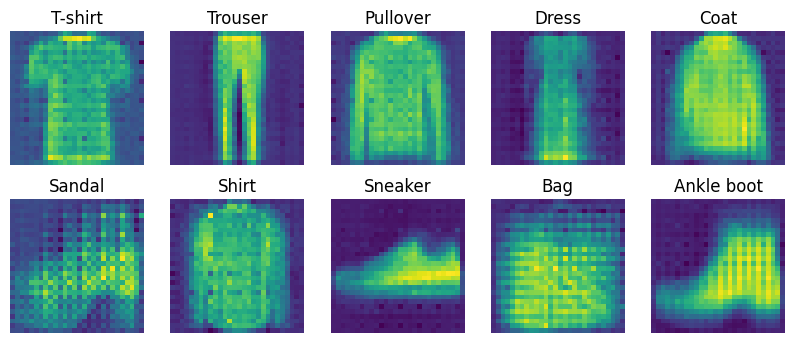

In [50]:
classes = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    invertible = SequentialFlow([*invNet.model[:-1]])## excluding distance regressor
    icenter = invertible.inverse(invNet.model[-1].centers.data)
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{classes[i]}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/FashionMNIST_InvretibleInvex_CNN_centroids2.pdf")
plt.show()